<a href="https://colab.research.google.com/github/CHYaswanth/SVHN-Image-classification/blob/master/SVHN_Digit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
# Initialize the random number generator
import random
random.seed(100)

#### Checking GPU allotment

In [50]:
from tensorflow import keras
tf.test.gpu_device_name()

'/device:GPU:0'

#### Mounting Drive

In [51]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the DataSet

In [52]:
import h5py
import numpy as np

#open file as readonly
h5f = h5py.File('/content/drive/My Drive/Neural Net Project/SVHN_single_grey1.h5', 'r')

h5f.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [0]:
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

#close file
h5f.close()

In [54]:
print('X train shape : ', X_train.shape)
print('y train shape : ', y_train.shape)
print('\n')

print('X val shape : ', X_val.shape)
print('y val shape : ', y_val.shape)
print('\n')

print('X test shape : ', X_test.shape)
print('y test shape : ', y_test.shape)
print('\n')

X train shape :  (42000, 32, 32)
y train shape :  (42000,)


X val shape :  (60000, 32, 32)
y val shape :  (60000,)


X test shape :  (18000, 32, 32)
y test shape :  (18000,)




### Visualizing the DataSet

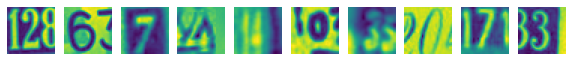

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [55]:
# visualizing the first 10 images in the Train set and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

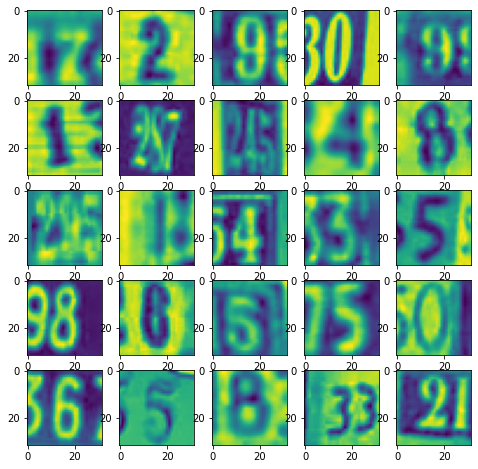

In [56]:
# visualizing the test set images
fig=plt.figure(figsize=(8, 8))
columns=5
rows=5
for i in range(1, columns*rows +1):
    img = X_test[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Data PreProcessing

In [0]:
# Changing dimensions to N x D = 32x32

X_tr = X_train.reshape(len(X_train), X_train.shape[1] * X_train.shape[2])
X_te = X_test.reshape(len(X_test), X_test.shape[1] * X_test.shape[2])
X_va = X_val.reshape(len(X_val), X_val.shape[1] * X_val.shape[2])

In [58]:
print('Shapes of test/train/validation sets:')
print('Test :', X_tr.shape)
print('Test :', X_te.shape)
print('Test :', X_va.shape)

Shapes of test/train/validation sets:
Test : (42000, 1024)
Test : (18000, 1024)
Test : (60000, 1024)


In [0]:
# normalizing input from 0-255 to 0-1

X_tr = X_tr / 255.0
X_te = X_te / 255.0
X_val = X_val /255.0

In [0]:
# converting y data into categorical (one-hot encoding)
from tensorflow.keras.utils import to_categorical

y_tr = to_categorical(y_train)
y_te = to_categorical(y_test)
y_va = to_categorical(y_val)

In [61]:
# combining train & val sets to add samples to train our model.
Xf_train = np.concatenate((X_tr,X_va))
yf_train = np.concatenate((y_tr, y_va))

print(Xf_train.shape, yf_train.shape)

(102000, 1024) (102000, 10)


In [0]:
# Seperating 20% of the combined samples as validation set.

from sklearn.model_selection import train_test_split

Xf_tr, Xf_va, yf_tr, yf_va = train_test_split(Xf_train,yf_train, test_size=0.2, random_state=100)

In [63]:
print('Final Shape of the train/test/val sets:')
print(Xf_tr.shape, X_te.shape, Xf_va.shape)
print(yf_tr.shape, y_te.shape,yf_va.shape)

Final Shape of the train/test/val sets:
(81600, 1024) (18000, 1024) (20400, 1024)
(81600, 10) (18000, 10) (20400, 10)


## Useful Functions

In [0]:
# Plotting the train/ validation loss

def plot_loss(history):
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='val')
  plt.title('Loss for train/val sets')
  plt.ylabel('Loss')
  plt.xlabel(' # of epoch')
  plt.legend(loc="upper left")

def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='val')
  plt.title('Accuracy for train/val sets')
  plt.ylabel('Accuracy')
  plt.xlabel(' # of epoch')
  plt.legend(loc="upper left")

# Basic NN

### Architecture

**Layer in Network (No.of Neurons in the layer)**  
Input Layer (1024) -> Layer 1 (500) -> Layer 2 (250) -> Layer 3 (100) -> Layer 4 (50) ->  Output Layer (10)   


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

## Fucntion for NN Model

In [0]:
def NN_model(iterations, lr, Lambda, activation, optimizer, verb=True, evaluate=False):

    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    activation_fn = activation
    opt_algo = optimizer
    
    #useful varibales.
    returns = []
    verbose = 0
    output_nodes = 10

    if(verb):
      verbose = 1
    
    model = Sequential()
    model.add(Dense(500, input_shape=(1024,), activation=activation_fn))
    model.add(Dense(250, activation=activation_fn))
    model.add(Dense(100, activation=activation_fn))
    model.add(Dense(50, activation=activation_fn))
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    ## optimizer 1
    sgd = optimizers.SGD(lr=learning_rate,decay=1e-6, momentum=0.9)
    
    ## optimizer 2
    adam = optimizers.Adam(lr = learning_rate)

    if(opt_algo == 'SGD'):
      opt_algo = sgd
    else:
      opt_algo = adam

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit the model
    history = model.fit(Xf_tr, yf_tr, epochs=iterations, batch_size=200, validation_data=(Xf_va,yf_va), verbose=verbose)
    returns.append(history)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plot_loss(history)

    plt.subplot(1,2,2)
    plot_accuracy(history)
    plt.show()

    if(evaluate):
      # model evaluation
      score = model.evaluate(X_te, y_te, verbose=0)
      returns.append(score)
    else:
      score = model.evaluate(Xf_va, yf_va, verbose=0)
      returns.append(score)

    return returns

## 1. Basic Neural network

lr = 0.01  
lamba = 0  
activation = 'sigmoid'  
optimizer = SGD  
model evaluation = false



Epoch 1/10
408/408 [==============================] - 2s 4ms/step - loss: 2.3049 - accuracy: 0.1020 - val_loss: 2.3035 - val_accuracy: 0.1156
Epoch 2/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3030 - accuracy: 0.1019 - val_loss: 2.3029 - val_accuracy: 0.1028
Epoch 3/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3025 - accuracy: 0.1038 - val_loss: 2.3009 - val_accuracy: 0.1075
Epoch 4/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3014 - accuracy: 0.1083 - val_loss: 2.3011 - val_accuracy: 0.1011
Epoch 5/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3002 - accuracy: 0.1153 - val_loss: 2.2988 - val_accuracy: 0.1026
Epoch 6/10
408/408 [==============================] - 1s 3ms/step - loss: 2.2981 - accuracy: 0.1185 - val_loss: 2.2992 - val_accuracy: 0.1010
Epoch 7/10
408/408 [==============================] - 1s 3ms/step - loss: 2.2947 - accuracy: 0.1391 - val_loss: 2.2917 - val_accuracy: 0.1426
Epoch 

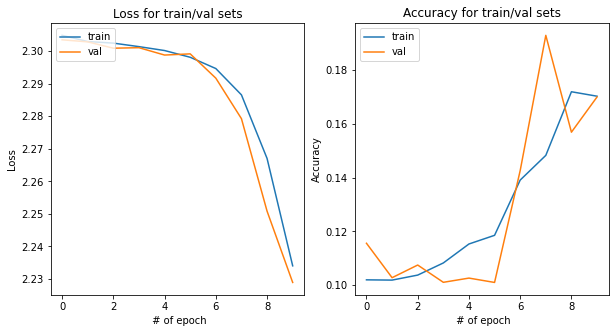

 [2.2289037704467773, 0.16995097696781158]]

In [67]:
NN_model(10, 0.01, 0, activation='sigmoid', optimizer='SGD')

**Train accuracy ~ 10 % is expected for un-trianed model. so model architecture of fine.**  



#### sanity check 

lr = 0.01  
lamba = 1e2 (high regularization) we expect loss to increase substantially  

All remaining paramters stay similar to the previous run. 

Epoch 1/10
408/408 [==============================] - 1s 3ms/step - loss: 43.4497 - accuracy: 0.0995 - val_loss: 2.3045 - val_accuracy: 0.1000
Epoch 2/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3058 - accuracy: 0.0993 - val_loss: 2.3082 - val_accuracy: 0.0982
Epoch 3/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3063 - accuracy: 0.1000 - val_loss: 2.3046 - val_accuracy: 0.1000
Epoch 4/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3063 - accuracy: 0.0986 - val_loss: 2.3036 - val_accuracy: 0.0990
Epoch 5/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3064 - accuracy: 0.0981 - val_loss: 2.3077 - val_accuracy: 0.0990
Epoch 6/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3059 - accuracy: 0.1009 - val_loss: 2.3057 - val_accuracy: 0.0978
Epoch 7/10
408/408 [==============================] - 1s 3ms/step - loss: 2.3059 - accuracy: 0.0990 - val_loss: 2.3045 - val_accuracy: 0.0990
Epoch

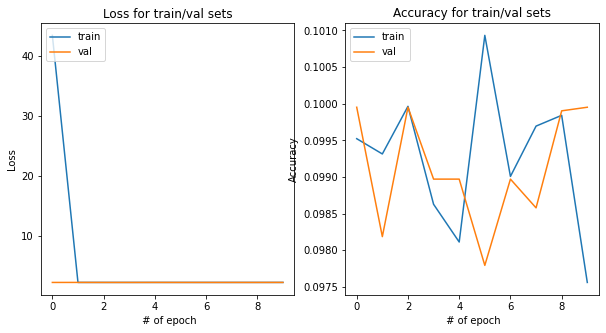

 [2.308145523071289, 0.09995097666978836]]

In [68]:
NN_model(10, 0.01, 1e2, activation='sigmoid', optimizer='SGD')

As expected loss has shooted up..  
So our model is performing as expected. 

So lets proceed to tune our hyperparameters 

## 2. With RELU activation and Adam Optimizer


Epoch 1/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0999 - val_loss: nan - val_accuracy: 0.0986
Epoch 2/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 3/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 4/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 5/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 6/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 7/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 8/10
408/408 [============================

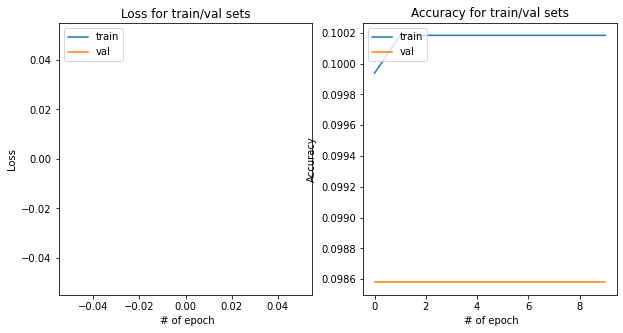

Model Accuracy is :  [nan, 0.09857843071222305]


In [69]:
lr = 0.01
Lambda = 0

model = NN_model(10, lr, Lambda, activation='relu', optimizer='adam')

print('Model Accuracy is : ', model[1]) 

We notice model performs much better with relu and adam. 
So we wil stick to activation = relu and optimizer = adam for this case study.


## 3. Hyper parameters ("Learning rate" and "lambda") Tuning

##### to evaluate the range for learning rate and lambda let us try with a very small value, followed by a very high values.

Epoch 1/10
408/408 [==============================] - 1s 3ms/step - loss: 4.1358 - accuracy: 0.1024 - val_loss: 2.3001 - val_accuracy: 0.1106
Epoch 2/10
408/408 [==============================] - 1s 3ms/step - loss: 2.2923 - accuracy: 0.1242 - val_loss: 2.2853 - val_accuracy: 0.1330
Epoch 3/10
408/408 [==============================] - 1s 3ms/step - loss: 2.2753 - accuracy: 0.1411 - val_loss: 2.2731 - val_accuracy: 0.1454
Epoch 4/10
408/408 [==============================] - 1s 3ms/step - loss: 2.2605 - accuracy: 0.1509 - val_loss: 2.2583 - val_accuracy: 0.1564
Epoch 5/10
408/408 [==============================] - 1s 3ms/step - loss: 2.2411 - accuracy: 0.1606 - val_loss: 2.2370 - val_accuracy: 0.1588
Epoch 6/10
408/408 [==============================] - 1s 3ms/step - loss: 2.2265 - accuracy: 0.1622 - val_loss: 2.2260 - val_accuracy: 0.1577
Epoch 7/10
408/408 [==============================] - 1s 3ms/step - loss: 2.2158 - accuracy: 0.1620 - val_loss: 2.2217 - val_accuracy: 0.1576
Epoch 

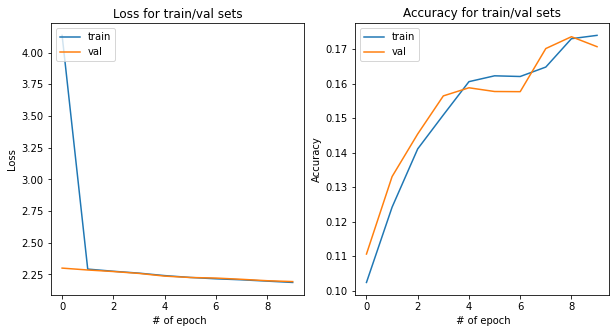

Model Accuracy is :  17.0686274766922


In [70]:
## small values for lr and lambda
lr = 1e-4
Lambda = 1e-6

model = NN_model(10, lr, Lambda, activation='relu', optimizer='adam')
print('Model Accuracy is : ', model[1][1]*100) 

Epoch 1/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1003 - val_loss: nan - val_accuracy: 0.0986
Epoch 2/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 3/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 4/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 5/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 6/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 7/10
408/408 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0986
Epoch 8/10
408/408 [============================

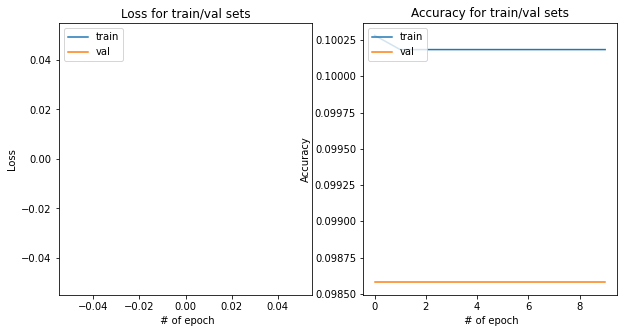

Model Accuracy is :  9.857843071222305


In [71]:
## Large values for lr and lambda

## By trail and error we see the below values as optimal values beyond which the loss is imploding.

lr = 1e-1
Lambda = 1e-2

model = NN_model(10, lr, Lambda, activation='relu', optimizer='adam')
print('Model Accuracy is : ', model[1][1]*100) 

**Now that we have set out lower and upper boundaries for our lr and lamba, lets now try to perform a random search in this range to find out out best hyperparameters**

In [0]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-4.0, -1.0))
    Lambda = math.pow(10, np.random.uniform(-6,-2))
    best_acc = NN_model(100, lr, Lambda, activation='relu', optimizer='adam', verb=False)
    print("Try {0}: Best_val_acc: {1}, lr: {2}, Lambda: {3}\n".format(k, best_acc[1][1]*100, lr, Lambda))

With Optimizer as 'Adam'

In [0]:
import math
for k in range(1,11):
    lr = math.pow(10, np.random.uniform(-4.0, -1.0))
    Lambda = math.pow(10, np.random.uniform(-5,-2))
    best_acc = NN_model(100, lr, Lambda, activation='relu', optimizer='adam', verb=False)
    print("Try {0}: Best_val_acc: {1}, lr: {2}, Lambda: {3}\n".format(k, best_acc[1][1]*100, lr, Lambda))